***Capstone 3 - Unsupervised Learning

Research Question: Your startup is creating an innovative new email software. How can you help them create an effective spam filter?
        - An effective spam filter can be created by understanding the difference between a spam and a non-spam email. Differences can be attributed to types of words used and the number of times they are used, sentence structure, types of files an email includes, a signiture at the bottom of an email, and so on. Writing an algorithm that would distinguish these differences will increase the chances of filtering a spam email.

Summary:
        - The objective of this task is to analyze the Spambase dataset, which consits of spam and non-spam emails, to obtain insights on how to distinguish between both by clustering them into different groups using unsupervised learning techniques. The dataset contains frequency of certain words used in an email, percentage of a certain character that is included in an email, and average, sum and lenght of uninterrupted capital letters used. The data does contain a target variable, which will be used to calculated the Adjusted Rand Index Score. The data was collected using reported spam emails by individuals and non-spam emails came from reported personal emails. The data can be accessed from kaggle by accessing the link: https://www.kaggle.com/somesh24/spambase


Methods: To analyze the dataset, the data will be cleaned and processed. If the data is not balanced, the data will be balanced to equate the number of samples from each group. Then, we will choose the number of clusters(k) by calculating the Sum of Squared Errors(SSE) and graph. After choosing the right number of clusters, four clustering algorithms: K-means, Hierarchical, DBSCAN, and GMM are implemented. To visualize the clusters in each algorithm, dimensionality reduciton techniques as PCA, t-SNE, and UMAP are implemented. Finally, the ARI and Silhoutte scores are calcualted to select the best performing model. 

In [15]:
#Install umap
!pip install umap-learn

In [16]:
#Import Libraries

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

#To calculate RI, AIR, and Silhouette Scores
from sklearn import metrics

In [17]:
#Read and Load the Spambase dataset
from google.colab import files

uploaded = files.upload()

Saving spambase.csv to spambase (1).csv


In [18]:
data=pd.read_csv("spambase.csv")

In [19]:
#Get information about the data

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

word_freq_make  word_freq_address  ...  capital_run_length_total  class
0            0.00               0.64  ...                       278      1
1            0.21               0.28  ...                      1028      1
2            0.06               0.00  ...                      2259      1
3            0.00               0.00  ...                       191      1
4            0.00               0.00  ...                       191      1

[5 rows x 58 columns]

Data is compomised of all numerical values. The value class denotes if an email is spam or not smap, represented by 1 and 0, respectively. 

In [20]:
#Lets double check if there are any null values
data.isnull().sum()

word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
word_freq_telnet              0
word_fre

As confirmed above, data does not have any missing null values. 

In [21]:
#Check the size of the data we will be working on
data.shape

(4601, 58)

Data contains 4601 rows and 58 columns. The target is the 58th variable. 

In [22]:
#Lets get statistics of the data
data.describe()

word_freq_make  word_freq_address  ...  capital_run_length_total        class
count     4601.000000        4601.000000  ...               4601.000000  4601.000000
mean         0.104553           0.213015  ...                283.289285     0.394045
std          0.305358           1.290575  ...                606.347851     0.488698
min          0.000000           0.000000  ...                  1.000000     0.000000
25%          0.000000           0.000000  ...                 35.000000     0.000000
50%          0.000000           0.000000  ...                 95.000000     0.000000
75%          0.000000           0.000000  ...                266.000000     1.000000
max          4.540000          14.280000  ...              15841.000000     1.000000

[8 rows x 58 columns]

Based on the large values shown by the last few variables, this dataset needs to be scaled, which we will do later on.

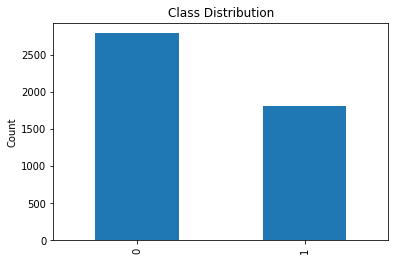

Number of non-spam emails:  2788
Number of spam emails:  1813
Percentage of spam emails in the data: 39.4 %


In [23]:
#Lets analyze our target variable

data['class'].value_counts().plot.bar()
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

print("Number of non-spam emails: ",len(data[data['class']==0]))
print("Number of spam emails: ",len(data[data['class']==1]))

print("Percentage of spam emails in the data:", str(round(100*len(data[data['class']==1])/len(data),2)),"%")

As the data shows, number of spam emails only account for 39.4% of the whole data. We will compare this to our prediction values obtained from using the features. 

In [24]:
#Data is imbalanced, lets balance so number of 1's and 0's will be equal.
g = data.groupby('class')
data=g.apply(lambda x: x.sample(g.size().min(),random_state=150).reset_index(drop=True))

In [25]:
data.shape
print("Number of non-spam emails: ",len(data[data['class']==0]))
print("Number of spam emails: ",len(data[data['class']==1]))

Number of non-spam emails:  1813
Number of spam emails:  1813


In [26]:
#Drop the target variable
X=data.drop(columns=['class'], axis=1)
y=data['class']

In [27]:
spam=data[data['class']==1].sum()
not_spam=data[data['class']==0].sum()

In [28]:
difference=not_spam-spam
print("If values are negative, corresponding features aid spam emails: \n{}".format(difference.sort_values(ascending=True)))

If values are negative, corresponding features aid spam emails: 
capital_run_length_total     -561887.000
capital_run_length_longest   -156440.000
capital_run_length_average    -12834.299
class                          -1813.000
word_freq_you                  -1806.980
word_freq_your                 -1744.560
word_freq_free                  -813.220
char_freq_%21                   -730.537
word_freq_our                   -560.440
word_freq_remove                -482.940
word_freq_000                   -435.770
word_freq_business              -435.720
word_freq_email                 -398.920
word_freq_all                   -361.990
word_freq_credit                -358.330
word_freq_money                 -352.610
word_freq_font                  -341.630
word_freq_mail                  -314.790
word_freq_internet              -312.970
word_freq_3d                    -296.190
char_freq_%24                   -295.284
word_freq_over                  -240.810
word_freq_order                 -

Based on the difference of frequency of particular words in each category, we see that the the values, either negative or positive, gives us an insight if frequency of words in a particular category support a spam or non-spam email. 

Because we are trying to seperate emails in to spam and not spam category, we assume that two cluster need to be established. However, we will still test to see how many clusters we can make 

In [29]:
#Lets test how many clusters we can create
number_k=range(1,10)
sse=[]
for i in number_k:
    km=KMeans(n_clusters=i)
    km.fit(X)
    sse.append(km.inertia_)

In [30]:
sse

[1736531163.451136,
 893358560.3867931,
 496394967.2940679,
 307489705.4975766,
 233074567.16448852,
 168803713.17244533,
 134693733.6048239,
 105341954.24348475,
 84665960.09807968]

Text(0.5, 0, 'K Values')

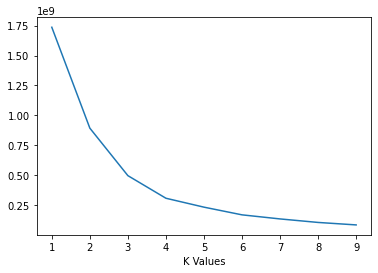

In [31]:
#Lets plot the SSE values to select the best 'k' value
plt.plot(number_k,sse)
plt.xlabel('K Values')

Based on the 'elbow' plot, we can have 4 clusters.

In [32]:
#Before we begin, lets Standardize the data
X_standard=StandardScaler().fit_transform(X)

In [33]:
# Lets try k=2 and k=4 and apply pca for each
# I will use random_state to compare different unsupervised learning algorithms

# Apply k=2
k2=KMeans(n_clusters=2, random_state=150).fit(X_standard)

k2_pred=k2.predict(X_standard)

#Now appy PCA where n_components=2

pca=PCA(n_components=2, random_state=150).fit_transform(X_standard)

colors='rb'
for i in range(pca.shape[0]):
    plt.text(pca[i,0], pca[i,1], str(k2_pred[i])),
    color=colors[k2_pred[i]],
    fontdict={'weight':'bold','size':50}
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
#Lets use TSNE

tsne=TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=150)
tsne_results=tsne.fit_transform(X_standard)

plt.figure(figsize=(10,5))
colours = ["r","b"]
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i, 0], tsne_results[i,1], str(k2_pred[i]),
             color=colours[int(k2_pred[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
#Apply Umap

umap_results=umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation',random_state=150).fit_transform(X_standard)
plt.figure(figsize=(10,5))
colours = ["r","b"]
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], k2_pred[i],
             color=colours[int(k2_pred[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

PCA did a better job at seperating 0's from 1's. TSNE is good too.

In [ ]:
# Apply k=4
k4=KMeans(n_clusters=4, random_state=150).fit(X_standard)

k4_pred=k4.predict(X_standard)

#Now appy PCA where n_components=2

pca=PCA(n_components=2, random_state=150).fit_transform(X_standard)
colors='rbgc'
for i in range(pca.shape[0]):
    plt.text(pca[i,0], pca[i,1], str(k4_pred[i])),
    color=colors[k4_pred[i]],
    fontdict={'weight':'bold','size':50}
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
#Lets use TSNE

tsne=TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=150)
tsne_results=tsne.fit_transform(X_standard)

plt.figure(figsize=(10,5))
colors='rbgc'
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i, 0], tsne_results[i,1], str(k4_pred[i]),
             color=colors[int(k4_pred[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
#Apply Umap

umap_results=umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=150).fit_transform(X_standard)
plt.figure(figsize=(10,5))
colors='rbgc'
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], k4_pred[i],
             color=colors[int(k4_pred[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Again, PCA & TSNE did better at clustering for k=4.

In [ ]:
#Function to calculate rand index score
def rand_index_score(ground_truths, predictions):
  tp_plus_fp=scipy.special.comb(np.bincount(predictions), 2).sum()
  tp_plus_fn=scipy.special.comb(np.bincount(ground_truths), 2).sum()
  A=np.c_[(ground_truths, predictions)]
  tp=sum(scipy.special.comb(np.bincount(A[A[:,0]==i,1]),2).sum()
          for i in set(ground_truths))
  
  fp=tp_plus_fp-tp
  fn=tp_plus_fn - tp
  tn=scipy.special.comb(len(A),2)-tp-fp-fn
  return(tp+tn)/(tp+fp+fn+tn)

In [ ]:
#Calculate RI, ARI, and Silhouette Scores
print("For k=2:")
print("RI:", rand_index_score(y, k2_pred))
print("ARI:", metrics.adjusted_rand_score(y, k2_pred))
print("Silhouette:", metrics.silhouette_score(X_standard, k2_pred, metric='euclidean'))

For k=2:
RI: 0.49993571333472814
ARI: 0.0001405947313288915
Silhouette: 0.6883341509923626


In [ ]:
print("For k=4:")
print("RI:", rand_index_score(y, k4_pred))
print("ARI:", metrics.adjusted_rand_score(y, k4_pred))
print("Silhouette:", metrics.silhouette_score(X_standard, k4_pred, metric='euclidean'))

K=4 provides better performance than k=2. Therefore, ideal k will equal to 4. 



*****************************************
***Now lets apply Hierarchical Clustering

In [ ]:
#Apply Hierarchical Clustering

#Primarily lets use dendogram to visualize our data and to choose our linkage

#Creating Dendograms
plt.title("Complete Dendogram")
dendrogram(linkage(X_standard, method='complete'))
plt.show()

plt.title("Average Dendogram")
dendrogram(linkage(X_standard, method='average'))
plt.show()

plt.title("Ward Dendogram")
dendrogram(linkage(X_standard, method='ward'))
plt.show()

Ward dendogram looks better, so, we will use it for our Hierarchical Clustering.

In [ ]:
#Apply Hierarchical Clustering

#Based on dendogram results, we will use ward linage with k=4.

ward_clust=AgglomerativeClustering(linkage='ward',
                                  affinity='euclidean',
                                  n_clusters=4).fit_predict(X_standard)



In [ ]:
#I will use PCA because it does better job at seperating the 4 clusters than TSNE and UMAP

pca=PCA(n_components=2, random_state=150).fit_transform(X_standard)
colors='rbgc'
for i in range(pca.shape[0]):
    plt.text(pca[i,0], pca[i,1], str(ward_clust[i])),
    color=colors[ward_clust[i]],
    fontdict={'weight':'bold','size':50}
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
#Lets use TSNE

tsne=TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=150)
tsne_results=tsne.fit_transform(X_standard)

plt.figure(figsize=(10,5))
colors='rbgc'
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i, 0], tsne_results[i,1], str(ward_clust[i]),
             color=colors[int(ward_clust[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
#Apply Umap

umap_results=umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=150).fit_transform(X_standard)
plt.figure(figsize=(10,5))
colors='rbgc'
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], ward_clust[i],
             color=colors[int(ward_clust[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

TSNE looks better at seperating the clusters.

In [ ]:
#Get Scores
print("Ward Linkage:",metrics.adjusted_rand_score(y, ward_clust))
print("Ward S.C:", metrics.silhouette_score(X_standard, ward_clust, metric='euclidean'))

***Now lets apply DBSCAN Clustering 

In [ ]:
#Define the DBSCAN Clustering
dbscan_clust=DBSCAN(eps=1, min_samples=5).fit_predict(X_standard)

#Apply PCA

pca=PCA(n_components=2, random_state=150).fit_transform(X_standard)
colors='rbgc'

for i in range(pca.shape[0]):
    plt.text(pca[i,0], pca[i,1], str(dbscan_clust[i])),
    #color=colors[dbscan_clust[i]],
    fontdict={'weight':'bold','size':50}
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
#Get Scores
print("ARI:",metrics.adjusted_rand_score(y, dbscan_clust))
print("S.C:", metrics.silhouette_score(X_standard, dbscan_clust, metric='euclidean'))

DBSCAN does not perform well.

In [ ]:
#Using Guassian Mixture Model
gmm_clust=GaussianMixture(n_components=4, random_state=150).fit_predict(X_standard)

#Apply PCA

pca=PCA(n_components=2, random_state=150).fit_transform(X_standard)
colors='rbgc'

for i in range(pca.shape[0]):
    plt.text(pca[i,0], pca[i,1], str(gmm_clust[i])),
    #color=colors[dbscan_clust[i]],
    fontdict={'weight':'bold','size':50}
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
tsne=TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=150)
tsne_results=tsne.fit_transform(X_standard)

plt.figure(figsize=(10,5))
colors='rbgc'
for i in range(tsne_results.shape[0]):
    plt.text(tsne_results[i, 0], tsne_results[i,1], str(gmm_clust[i]),
             color=colors[gmm_clust[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
#Apply Umap

umap_results=umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=150).fit_transform(X_standard)
plt.figure(figsize=(10,5))
colors='rbgc'
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], gmm_clust[i],
             color=colors[gmm_clust[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

It seems TSNE and UMAP did better than PCA.

In [ ]:
#Get scores:
print("ARI:",metrics.adjusted_rand_score(y, gmm_clust))
print("S.C:", metrics.silhouette_score(X_standard, gmm_clust, metric='euclidean'))

In [ ]:
#ARI and Silhouette score comparison of K-Means, DBSCAN, Hierarchical, and GMM clustering algorithms

k_means=metrics.adjusted_rand_score(y, k4_pred)
hierarchical=metrics.adjusted_rand_score(y, ward_clust)
dbscan=metrics.adjusted_rand_score(y, dbscan_clust)
gmm=metrics.adjusted_rand_score(y, gmm_clust)

#Array to hold ari scores
ari_scores=[k_means, hierarchical, dbscan, gmm]

k_means_sc=metrics.silhouette_score(X_standard, k4_pred, metric='euclidean')
hierarchical_sc=metrics.silhouette_score(X_standard, ward_clust, metric='euclidean')
dbscan_sc=metrics.silhouette_score(X_standard, dbscan_clust, metric='euclidean')
gmm_sc=metrics.silhouette_score(X_standard, gmm_clust, metric='euclidean')

sc_scores=[k_means_sc, hierarchical_sc, dbscan_sc, gmm_sc]

In [ ]:
algorithms=['K-Means', 'DBSCAN', 'Hierarchical', 'GMM']

results=pd.DataFrame({'ARI Scores': ari_scores,
                     'Silhouette Scores':sc_scores}, index=algorithms)

In [ ]:
results

In [ ]:
ax=results.plot.bar(rot=0)
plt.title('ARI & Silhouette Scores')

Results:

The implementation of k-means, DBSCAN, Hierarchical, and GMM clustering algorithms with dimenisonality reduction techniques as PCA, t-SNE, and UMAP demonstrated how individual data points can be clustered into certain groups that can be used to indicate if that certain group is a spam email. Based on visual insight on how the clusters are grouped in each clustering algorithm using three dimensionality reduction techniques, and by further calculating the Adjusted Rand Index and Silhouette scores, DBSCAN is the best clustering algorithm to be utalized with an ARI score of 0.21 even though its Silhouette score is lower than Silhouette score of K-Means. The second best algorithm is K-Means. GMM has the highest ARI score of 0.29 but its Silhouette score is below 0.

Though ARI score is not high, this analysis indicates which clustering algorithm would likely give us the best performance if our data was larger with more samples and more examples of frequency of words used. 